# Spectral Density

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm_notebook
from pathlib import Path

import os
import pickle
import matplotlib.pyplot as plt

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero

    min_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])

    return min_psd

In [4]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [5]:
def __get_minimum_psd(psds, f_tmp):

    for i, psd in enumerate(psds):
        if i == 0:
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum()

        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    return psds[idx]

In [6]:
def __get_array_from_dataframe(df):

    from pandas import to_numeric

    ## convert to list
    psds = []
    for col in array(df.columns):

        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

## Configurations

In [7]:
## ---------------------------------------

# name, comp, app = "PROMY", "", ""
name, comp, app = "FFBI", "", "_absolute"
# name, comp, app  = "ROMY", "Z", ""
# name, comp, app = "ROMY", "U", ""
# name, comp, app = "ROMY", "V", ""

year = "2023"

path = data_path+f"LNM2/PSDS/"

t1 ,t2 = "2023-09-23", "2023-10-23"

In [8]:
## ---------------------------------------

## load configurations
if len(comp) != 0:
    config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_{comp}_3600_config.pkl", 'rb'))
    config['filename'] = f"{name}{app}/{year}_{name}_{comp}_3600"
    config['station'] = f"{name}_{comp}"
else:
    config = pickle.load(open(path+name+app+"/"+f"{year}_{name}_3600_config.pkl", 'rb'))
    config['filename'] = f"{name}{app}/{year}_{name}_3600"
    config['station'] = f"{name}"


config['path'] = path

config['startdate'], config['enddate'] = t1, t2



## specify paths
config['outpath_figures'] = data_path+f"LNM2/figures/"

config['path_to_outdata'] = data_path+f"LNM2/data/"

## Methods

In [9]:
def __load_psd_files(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    year = str(tbeg.year)

    df = DataFrame()
    for dat in date_range(dd1, dd2):
        file = f"{year}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to defined times
    df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t))  for _t in df['times_utc']]

    return df

In [10]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [11]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [12]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [13]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [14]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)



    ##____________________________


    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

    axes.set_xlim(1e-3, 2e1)
#     axes.set_ylim(1e-23, 1e-16)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    # axes.set_ylabel(r"PSD$_{absolute}$ ($hPa$/$Hz)$", fontsize=font)
    axes.set_ylabel(r"PSD$_{infrasound}$ ($hPa$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))

    axes.set_title(f"{config['station']} | {day}")

    plt.show();
    return fig

In [15]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    ## convert frequencies to periods
    pp=[]
    for mm in range(len(ff)):
        ppp = zeros(len(ff[mm]))
        ppp = 1/ff[mm]
        pp.append(ppp)


    ##____________________________

    NN = 3

    fig, axes = plt.subplots(NN,1, figsize=(10,10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

#     N = max(psds[0].shape[0], psds[1].shape[0], psds[2].shape[0])
#     colors = plt.cm.rainbow(linspace(0, 1, N))

    N = 24
    colors = plt.cm.rainbow(linspace(0,1,N))
    cmap = plt.get_cmap('rainbow', 24)


    ## add Frequency Axis
#     g = lambda x: 1/x
#     ax2 = axes[0].secondary_xaxis("top", functions=(g,g))
#     ax2.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)
#     ax2.set_xticklabels(ff[2], fontsize=11)
#     ax2.tick_params(axis='both', labelsize=font-2)


    for j in range(NN):
        for n, psd in enumerate(tqdm(psds[j])):
            axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
            p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N)

        for reject in rejected[j]:
             axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=1)

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")


        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .99, 'a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font+2)
    axes[1].text(.01, .99, 'b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font+2)
    axes[2].text(.01, .99, 'c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font+2)

    axes[0].set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
    axes[1].set_ylabel(r"PSD$_{north}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)
    axes[2].set_ylabel(r"PSD$_{east}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

## RUN for all files 

In [41]:
psds_medians_out, times_out = [], []

ff = pickle.load(open(config['path']+f"{config['filename']}_frequency_axis.pkl", 'rb'))

dat, dates = [], []
for jj, day in enumerate(date_range(config['startdate'], config['enddate'])):

    # if jj > 2:
    #     continue


    day = str(day).split(" ")[0].replace("-", "")


    ## skip if file does not exist
    if not os.path.isfile(config['path']+f"{config['filename']}_{day}_hourly.pkl"):
        print(f" -> skipping {config['filename']}_{day}_hourly.pkl ...")
        continue

    print("loading " + day)

    try:
        _dat = __load_data_file(path, f"{config['filename']}_{day}_hourly.pkl")
        # _dat, rejected = __remove_noisy_psds(_dat, threshold_mean=1e-19, ff=ff, flim=0.1)

    except Exception as e:
        print(e)
        print(f" -> {day}: no data found")
        continue

    for _k, _psd in enumerate(_dat):
        dat.append(_psd)
        dates.append(f"{day}_{str(_k).rjust(2, '0')}")

dat = array(dat)

loading 20230923
loading 20230924
loading 20230925
loading 20230926
loading 20230927
loading 20230928
loading 20230929
loading 20230930
loading 20231001
loading 20231002
loading 20231003
loading 20231004
loading 20231005
loading 20231006
loading 20231007
loading 20231008
loading 20231009
loading 20231010
loading 20231011
loading 20231012
loading 20231013
loading 20231014
loading 20231015
loading 20231016
loading 20231017
loading 20231018
loading 20231019
loading 20231020
loading 20231021
loading 20231022
loading 20231023


In [42]:
from functions.get_hist_loglog import __get_hist_loglog

array([[4.81439196e+03, 3.28262405e+04, 5.30454397e+03, ...,
        1.02508236e-07, 7.43043814e-07, 2.00503488e-05],
       [1.34087127e+04, 5.44092486e+05, 3.66248966e+03, ...,
        5.33096981e-05, 8.98937955e-05, 2.75368524e-05],
       [9.02536410e+04, 1.82566418e+05, 4.19285297e+04, ...,
        5.02905138e-06, 6.89423286e-05, 5.53944607e-05],
       ...,
       [8.61286110e+03, 4.03599565e+04, 5.24790108e+04, ...,
        2.01338387e-04, 1.62374311e-04, 2.59837406e-05],
       [4.82842913e+04, 2.03309048e+05, 1.67174516e+04, ...,
        2.72116135e-05, 4.21447941e-05, 1.24010065e-05],
       [4.44996665e+01, 3.05039092e+05, 1.52072947e+05, ...,
        2.81715216e-05, 1.06604544e-04, 2.59181869e-05]])

In [45]:
def __get_hist_loglog(psd_array, ff, bins=20, density=False, axis=1, plot=False):

    import matplotlib.pyplot as plt
    from numpy import argmax, std, median, isnan, array, histogram, nan, zeros, count_nonzero, isinf, log10, nanmax, nanmin, nonzero
    from scipy.stats import median_abs_deviation as mad

    def __convert_to_log(in_psds):

        out_psds = zeros(in_psds.shape)
        rows_with_zeros = 0

        for i, psd in enumerate(in_psds):
            if count_nonzero(psd) != len(psd):
                rows_with_zeros += 1
                psd = [nan for val in psd if val == 0]
            out_psds[i,:] = log10(psd)
            if isinf(out_psds[i,:]).any():
                out_psds[i,:] = nan * ones(len(out_psds[i,:]))

        print(f" -> rows with zeros: {rows_with_zeros}")

        return out_psds

    ## converting to log10
    psd_array = __convert_to_log(psd_array)

    ## exclude psds with only NaN values
    psds = array([psd for psd in psd_array if not isnan(psd).all()])
    print(f" -> total spectra used: {psd_array.shape[0]}")

    ## find overall minimum and maxium values
    # max_value = max([max(sublist) for sublist in psd_array])
    # min_value = min([min(sublist) for sublist in psd_array])
    max_value = max(psd_array.reshape(psd_array.size))
    min_value = min(psd_array.reshape(psd_array.size))
    # print(min_value, max_value)

    ## define empty lists
    dist, dist_maximas, bins_maximas, bins_medians, stds, mads = [], [], [], [], [], []

    count = 0
    for h in range(len(psd_array[axis])):

        psd = psd_array[:, h]

        ## compute histograms
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=density);

        ## center bins
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])

        ## normalization
#         if True:
#             hist = [val / len(psd_array[:,h]) for val in hist]
#             config['set_density'] = True

        ## check if density works
        # DX = abs(max_value-min_value)/bins
        # SUM = sum(hist)
        # if str(SUM*DX) != "1.0":
        #     count += 1

        ## modify histogram with range increment
        # hist = hist*DX
        hist = [h / sum(hist) for h in hist]


        ## append values to list
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        mads.append(mad(hist))

        ## compute median
        psd = psd[~(isnan(psd))]
        bins_medians.append(median(psd[psd != 0]))

    ## undo log conversion
    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = 10**array(bin_mids)
    output['bins_maximas'] = 10**array(bins_maximas)
    output['stds'] = 10**array(stds)
    output['mads'] = 10**array(mads)
    output['bins_medians'] = 10**array(bins_medians)
    output['set_density'] = density
    output['total'] = psd_array.shape[0]
    output['frequencies'] = ff


    ## check plot
    if plot:
    # _ff[0] = 1e-21

        fig = plt.figure(figsize=(15, 5))
        cmap = plt.colormaps.get_cmap('viridis')
        cmap.set_under(color='white')

        _tmp = output['dist'].reshape(output['dist'].size)
        cb = plt.pcolormesh(ff, output['bin_mids'], output['dist'].T, cmap=cmap, shading="auto",
                       antialiased=True, vmin=min(_tmp[nonzero(_tmp)]), norm="log")

        plt.yscale("log")
        plt.xscale("log")

        plt.colorbar(cb)

        plt.xlabel("Frequency (Hz)")
        plt.ylabel("PSD")

        plt.xlim(ff[1], ff[-1])

        plt.show();

    if count > 0:
        print(f" -> {count}/{len(psd_array[axis])} errors found for density computation!!!")

    return output

In [46]:
# from numpy import isnan
# for d in dat.reshape(dat.size):
#     if not isnan(d):
#         print(d)

 -> rows with zeros: 0
 -> total spectra used: 744
-11.365789369854877 6.750741077144048


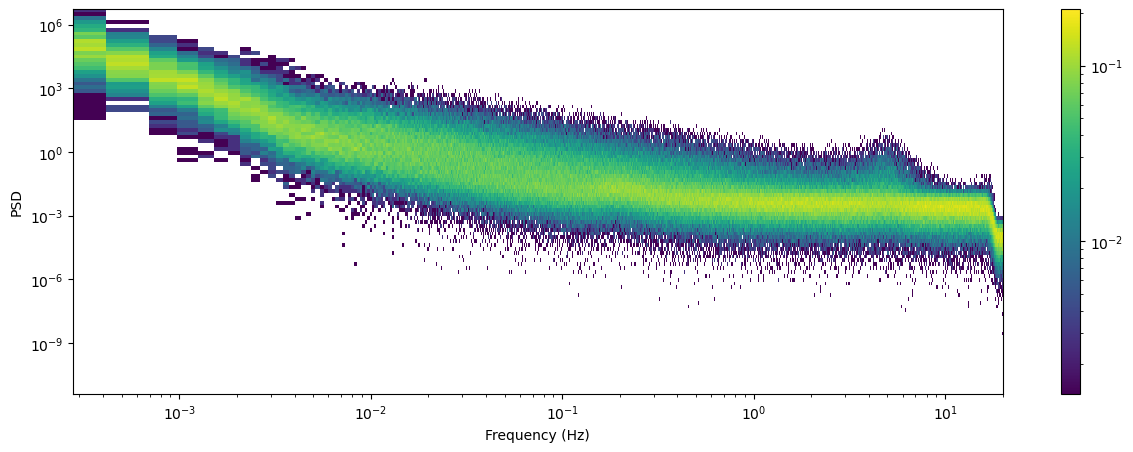

In [47]:
out = __get_hist_loglog(dat, ff, bins=100, density=False, axis=1, plot=True)

## Plotting

In [60]:
def __makeplot_density(out):

    import matplotlib.pyplot as plt
    import numpy as np


    def __get_median_psd(psds):

        from numpy import median, zeros, isnan

        med_psd = zeros(psds.shape[1])

        for f in range(psds.shape[1]):
            a = psds[:,f]
            med_psd[f] = median(a[~isnan(a)])

        return med_psd

    psd_median = __get_median_psd(dat)

    font = 14

    fig, ax = plt.subplots(1, 1, figsize=(15, 8))

    ## add Frequency Axis
    # g = lambda x: 1/x
    # ax2 = ax.secondary_xaxis("top", functions=(g, g))
    # ax2.set_xlabel("Frequency (Hz)", fontsize=font, labelpad=5)
    # ax2.set_xticklabels(ff, fontsize=11)

    ## theoretical rlnm
    # plt.plot(periods, rlnm_psd, color="black", zorder=2, lw=2, ls="--", label="RLNM")

    out['dist'] = np.ma.masked_array(out['dist'], out['dist'] == 0)

    y_axis = 10**(out['bin_mids']/10)
    x_axis = out['frequencies']

    if x_axis[0] == 0:
        x_axis[0] == 1e-20

    ## plotting

    cmap = plt.colormaps.get_cmap('viridis')
    # cmap.set_under(color='white')

    _tmp = out['dist'].reshape(out['dist'].size)
    # im = plt.pcolormesh(out['frequencies'], out['bin_mids'], out['dist'].T, cmap=cmap, shading="auto",
    #                     antialiased=True, vmin=min(_tmp[np.nonzero(_tmp)]), zorder=2)
    im = plt.pcolormesh(out['frequencies'], out['bin_mids'], out['dist'].T, cmap=cmap, shading="auto",
                        antialiased=True, vmin=min(_tmp[np.nonzero(_tmp)]), zorder=2, norm="log")

    plt.xscale("log")
    plt.yscale("log")

    plt.xlim(1e-3, 1e1)

    # plt.ylim(1e-24, 1e-15)

#     plt.fill_betweenx(np.linspace(ymin,ymax,5), x1=0, x2=2.5, color="lightgrey", alpha=0.4, zorder=2)
#     plt.fill_betweenx(np.linspace(ymin-10,ymax+10,5), x1=100, x2=300, color="lightgrey", alpha=0.4, zorder=2)

    plt.tick_params(axis='both', labelsize=font-1)

    plt.grid(axis="both", which="both", ls="--", zorder=1)
    # plt.legend()

    plt.xlabel("Frequency (Hz)", fontsize=font)
    plt.ylabel(r"PSD ($rad^2 /s^2 /Hz$)", fontsize=font)
    # plt.ylabel(r"PSD ($Pa^2 /Hz$)", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.91, 0.11, 0.02, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(im, cax=cbar_ax)
    cb.set_label("Propability Density", fontsize=font, labelpad=-48, color="white")

    plt.show();
    return fig

/tmp/ipykernel_769411/3434109713.py:36: RuntimeWarning: overflow encountered in power
  y_axis = 10**(out['bin_mids']/10)


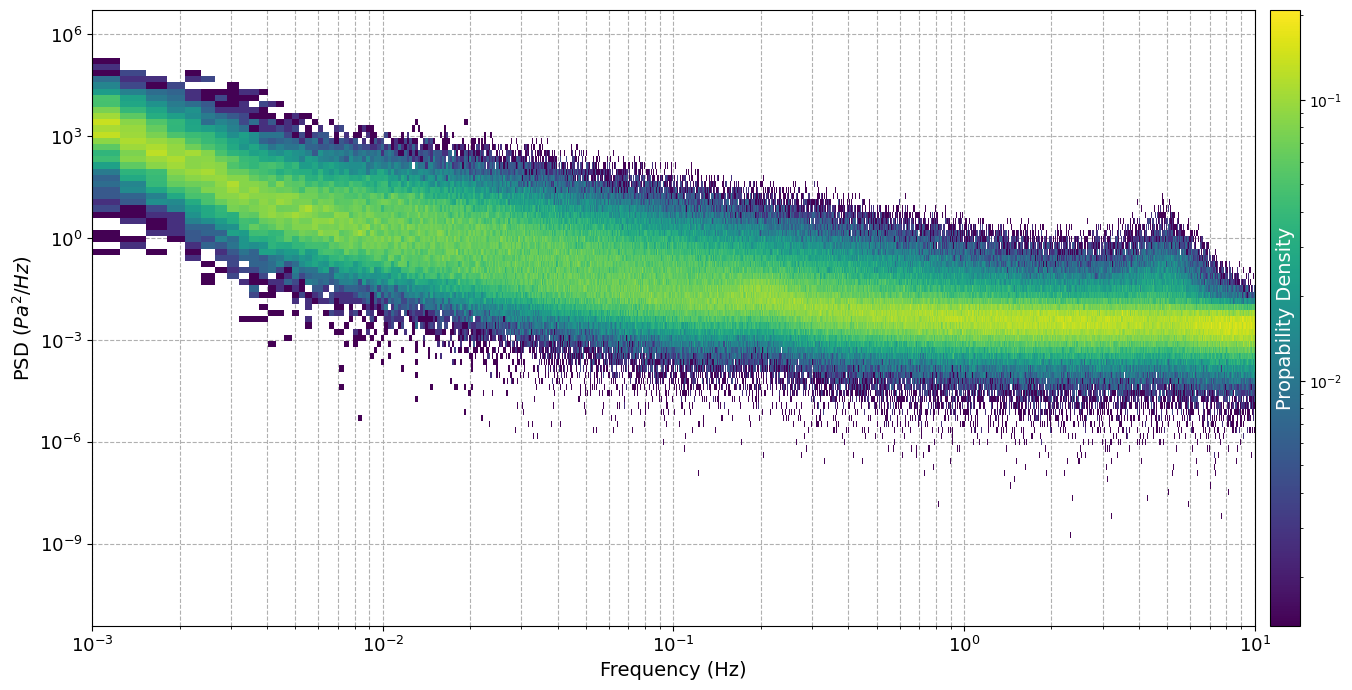

In [61]:
fig = __makeplot_density(out)

In [62]:
fig.savefig(config['outpath_figures']+f"SpectraDensity_{name}_{comp}_{app}.png", format="png", dpi=200, bbox_inches='tight')

## Get median and store

In [ ]:
psd_median = __get_median_psd(dat)

out_df = DataFrame()
out_df['psds_median'] = psd_median
out_df['frequencies'] = ff

out_df.to_pickle(config['path_to_outdata']+f"{year}_{name}_{comp}_psd_median.pkl")